# Download packages via pip, import libraries, connect to drive

## Install packages

In [ ]:
! pip install -q transformers

In [ ]:
! git clone https://github.com/MateVaradi/OscarPrediction.git

Cloning into 'OscarPrediction'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 211 (delta 6), reused 7 (delta 3), pack-reused 194
Receiving objects: 100% (211/211), 1.90 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (113/113), done.


## Import libraries

In [ ]:
# For data preprocessing
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# To get text embeddings with DistilBert
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# For ml operations
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import sklearn

# For data plotting
import plotly.express as px
import plotly
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import os # to manipulate paths to files
import time # to check time
import pickle # to upload and download files
import copy # to copy variables

from google.colab import drive # to connect to your drive

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## Connect to the drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Upload and clean data

## Upload the data

In [ ]:
# Upload reviews as dicts
with open('/content/drive/MyDrive/project/full_rt_20_mc_reviews_dicts/full_rt_dict.pkl', 'rb') as file:
    full_rt_dict = pickle.load(file)

with open('/content/drive/MyDrive/project/full_rt_20_mc_reviews_dicts/full_mc_dict.pkl', 'rb') as file:
    full_mc_dict = pickle.load(file)

In [ ]:
# Upload dataframes
df_with_reviews = pd.read_csv('/content/OscarPrediction/data/oscardata_bestpicture.csv')
df_wt_reviews = pd.read_csv('/content/OscarPrediction/data/oscardata_bestpicture.csv')

## Clean the data

In [ ]:
# Drop duplicates
df_wt_reviews = df_wt_reviews.drop_duplicates()
df_with_reviews = df_with_reviews.drop_duplicates()

In [ ]:
# Get identical movie's index
identical = df_wt_reviews['Film'].value_counts()
print(identical[0:1])
df_wt_reviews[df_wt_reviews['Film'] == 'West Side Story']

West Side Story    2
Name: Film, dtype: int64


,Category,Film,Nominee,Winner,Year,Rating_IMDB,Release_date,Rating_rtaudience,Rating_rtcritic,Oscarstat_totalnoms,...,Nonom_Criticschoice,Nom_Criticschoice,Nowin_SAG_bestcast,Win_SAG_bestcast,Nonom_SAG_bestcast,Nom_SAG_bestcast,Nowin_PGA,Win_PGA,Nonom_PGA,Nom_PGA
5,Picture,West Side Story,West Side Story,1,1962,7.6,1961-12-23,84,94,11,...,0,0,0,0,0,0,0,0,0,0
359,Picture,West Side Story,West Side Story,0,2022,7.5,09 Dec 2021,94,92,7,...,0,1,1,0,1,0,1,0,0,1


### Drop film by 1962 and map reviews

In [ ]:
# Drop film West Side Story by 1962 for both dataframes cause it already has one movie with the same name
df_wt_reviews = df_wt_reviews.drop(index=5)
df_wt_reviews = df_wt_reviews.reset_index(drop=True)

df_with_reviews = df_with_reviews.drop(index=5)
df_with_reviews = df_with_reviews.reset_index(drop=True)

In [ ]:
# Add reviews to dataframe with reviews
df_with_reviews['rt reviews'] = df_with_reviews['Film'].map(full_rt_dict)
df_with_reviews['mc reviews'] = df_with_reviews['Film'].map(full_mc_dict)

# Initialize model, check tests and get embeddings. You can skip this part and upload embeddings directly

In [ ]:
# Get reviews as lists if you are going to get embeddings
rt_reviews = df_with_reviews['rt reviews']
mc_reviews = df_with_reviews['mc reviews']

## Initialize model

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model.to(device)

In [ ]:
model.classifier

## Run some tests
You can skip the following code and just get the embeddings

In [ ]:
text = ["Hello, my dog is cute, but it poo's and it stinks often. However, I love it",
        "Hiii, My name is Stepan"]

inputs = tokenizer(text, return_tensors="pt", padding='longest')
inputs.to(device)
distilbert_output = model.distilbert(**inputs)

print("Input_ids shape = ", inputs.input_ids.shape)

hidden_state = distilbert_output[0]
print('Hidden_state shape', hidden_state.shape)

### Get logits

In [ ]:
pooled_output = hidden_state[:, 0]  # (bs, dim)
# pooled_output = torch.mean(hidden_state, dim=1)
print(pooled_output.shape)
pooled_output = model.pre_classifier(pooled_output)  # (bs, dim)
print(pooled_output.shape)
pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
print(pooled_output.shape)
pooled_output = model.dropout(pooled_output)  # (bs, dim)
print(pooled_output.shape)
logits = model.classifier(pooled_output)  # (bs, num_labels)

In [ ]:
# Check logits
logits

### Get mood for both sentences

In [ ]:
predicted_class_id = logits[0].argmax().item()
print("First sentiment - ", model.config.id2label[predicted_class_id])

predicted_class_id = logits[1].argmax().item()
print("Second sentiment - ", model.config.id2label[predicted_class_id])

## Get embeddings. Everything as one function

In [ ]:
def get_hidden_state(reviews):
    """
    get hidden states
    """
    with torch.no_grad():
        # If there is nan instead of reviews thenreturn None
        if type(reviews) == type(np.nan):
            return None

        inputs = tokenizer(reviews, return_tensors="pt", padding='longest')
        inputs.to(device)
        distilbert_output = model.distilbert(**inputs)
        hidden_state = distilbert_output[0]
        hidden_state = hidden_state[:, 0]
        # Uncomment this string to get hidden states mean
        # hidden_state = torch.mean(hidden_state, dim=0)
        return hidden_state

def get_prediction(hidden_state):
    """
    Get prediction if prediction parameter is True in get_embeddings function
    """
    with torch.no_grad():

        pooled_output = model.pre_classifier(hidden_state)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = model.dropout(pooled_output)  # (bs, dim)
        logits = model.classifier(pooled_output)  # (bs, num_labels)

        return logits

def get_embeddings(data, prediction=False):

    """
    This fucntion takes in data parameter that is dict and contains text reviews and add to it embeddings
    """

    # Copy data
    copied_data = copy.deepcopy(data)

    # loop over review's dict {'mc_reviews':mc_reviews, 'rt_reviews':rt_reviews} that were uploaded recently in the notebook
    for j, (key, text_nested_list) in enumerate(copied_data.items()):
        # initialise lists
        hidden_states_list, prediction_list, sentiment_list = [], [], []
        # iterate over reviews for each film
        for i, text_list in enumerate(text_nested_list):

            hidden_state = get_hidden_state(text_list)

            # Get embeddings as a prediction if prediction parameter is True
            if prediction:
                if hidden_state != None:
                    logits = torch.mean(get_prediction(hidden_state), dim=0)
                    predicted_class_id = logits.argmax().item()
                    sentiment = model.config.id2label[predicted_class_id]

                    prediction_list.append(logits.detach().cpu().numpy())
                    sentiment_list.append(0 if sentiment == 'NEGATIVE' else 1)

                else: prediction_list.append(None); sentiment_list.append(None)

            # Append hidden state
            if hidden_state != None: hidden_states_list.append(torch.mean(hidden_state, dim=0).detach().cpu().numpy())
            else: hidden_states_list.append(None)

            if i%100==0:
                print("Number of iteration - ", i)

        # Add embeddings to data parameter
        data[key+'_hidden_states'] = hidden_states_list
        data[key+'_prediction_list'] = prediction_list
        data[key+'_sentiment_list'] = sentiment_list

    return data

In [ ]:
# Use functions above
data = {'mc_reviews':mc_reviews, 'rt_reviews':rt_reviews}
data = get_embeddings(data, prediction=True)

In [ ]:
data.keys()

In [ ]:
# shapes = [s.shape for s in rt_hidden_states_list]
# sorted(shapes)

## Save embeddings

In [ ]:
with open('/content/drive/MyDrive/project/embeddings/full_data_dict.pkl', 'wb') as file:
    pickle.dump(data, file)

# Load embeddings, preprocess data, get train and test data

## Load embeddings

In [ ]:
with open('/content/drive/MyDrive/project/embeddings/full_data_dict.pkl', 'rb') as file:
    data = pickle.load(file)

In [ ]:
# Retrieve the lists with data
rt_hidden_states_list, mc_hidden_states_list = data['rt_reviews_hidden_states'], data['mc_reviews_hidden_states']
rt_reviews_prediction_list, mc_reviews_prediction_list = data['rt_reviews_prediction_list'], data['mc_reviews_prediction_list']
rt_reviews_sentiment_list, mc_reviews_sentiment_list = data['rt_reviews_sentiment_list'], data['mc_reviews_sentiment_list']

## Preprocess data

In [ ]:
def fill_in_mean_values(data_list):

    """
    This function take in data_list parameter, calculates the average variable for it and fill in average
    """
    temporary_list = []

    # Use it to avoid get None value as a type for the whole list
    temporary_type, i = type(None), 0
    while temporary_type == type(None):
        temporary_type = type(data_list[i])
        i += 1
    str_type = str(temporary_type)

    # Get not nan values
    for i in range(len(data_list)):
        if str(data_list[i]) != 'None':
            temporary_list.append(data_list[i])

    # form np arrays
    temporary_list_numpy = np.array(temporary_list)

    # Get means and type
    mean_tensor = np.mean(temporary_list_numpy, axis=0)
    if 'int' in str_type:
        mean_tensor = np.round(mean_tensor).astype(int)

    # Fill in means
    data_list = [arr if type(None) != type(arr) else mean_tensor for arr in data_list]

    return data_list

In [ ]:
# Fill average to the film that do not have mc reviews. YOU COULD USE IT AND FOR RT EMBEDDINGS IF THERE ARE SUCH FILMS
mc_hidden_states_list = fill_in_mean_values(mc_hidden_states_list)
mc_reviews_prediction_list = fill_in_mean_values(mc_reviews_prediction_list)
mc_reviews_sentiment_list = fill_in_mean_values(mc_reviews_sentiment_list)

In [ ]:
# Form rt and mc dataframes
d = mc_hidden_states_list[0].shape[0]
rt_df = pd.DataFrame(rt_hidden_states_list, columns=[f'rt_embed_index_{i}' for i in range(d)])
mc_df = pd.DataFrame(mc_hidden_states_list, columns=[f'mc_embed_index_{i}' for i in range(d)])

rt_prediction_df = pd.DataFrame(rt_reviews_prediction_list, columns=['rt_first_dim', 'rt_second_dim'])
mc_prediction_df = pd.DataFrame(mc_reviews_prediction_list, columns=['mc_first_dim', 'mc_second_dim'])

rt_sentiment_df = pd.DataFrame(rt_reviews_sentiment_list, columns=['rt_sentiment'])
mc_sentiment_df = pd.DataFrame(mc_reviews_sentiment_list, columns=['mc_sentiment'])

In [ ]:
# Get rid of some columns
y = df_wt_reviews['Winner']
df_wt_reviews = df_wt_reviews.drop(['Category', 'Film', 'Nominee', 'Year', 'Release_date', 'MPAA_rating', 'Winner'], axis=1)

In [ ]:
# Make one dataframe with embeddings
df_with_embeddings = pd.concat([df_wt_reviews, rt_df, mc_df], axis=1)
df_em_only = pd.concat([rt_df, mc_df], axis=1)

df_with_prediction_sentiment = pd.concat([df_wt_reviews, rt_prediction_df,
                                          mc_prediction_df, rt_sentiment_df,
                                          mc_sentiment_df], axis=1)

df_with_rt_embeddings = pd.concat([df_wt_reviews, rt_df], axis=1)
df_with_mc_embeddings = pd.concat([df_wt_reviews, mc_df], axis=1)

df_all = pd.concat([df_with_embeddings, df_with_prediction_sentiment], axis=1)

In [ ]:
# For dict dataframes with old dataframes
dataframes = {'df_with_embeddings':df_with_embeddings,
              'df_wt_embeddings': df_wt_reviews,
              'df_em_only':df_em_only,
              'df_with_prediction_sentiment':df_with_prediction_sentiment,
              'df_with_rt_embeddings': df_with_rt_embeddings,
              'df_with_mc_embeddings':df_with_mc_embeddings,
              'df_all':df_all}

## Get train, test data

In [ ]:
# Initialize the StandardScaler
def scale_data(df):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    return scaled_data

# Fit and transform the numerical data using StandardScaler and associate it with dataframes varable
for k, df in dataframes.items():
    scaled_df = scale_data(df)
    dataframes[k] = scaled_df

In [ ]:
# define parameters for train_test_split and split the data
test_size = 0.2
random_state=43
data_dict = copy.deepcopy(dataframes)

def data_split(X,y, test_size=0.5, random_state=43):
    return train_test_split(X,y, test_size=test_size, random_state=random_state)

for k, df in data_dict.items():
    t = (X_train, X_test, y_train, y_test) = data_split(X=df,y=y,test_size=test_size,
                                                        random_state=random_state)
    data_dict[k] = t

### Make sure that the data is splitted correctly, i.e. splits are made in such way that we can see the difference between data with text embeddings as 768 tensor dim and 2 tensor dim with sentiment mark and without embeddings

In [ ]:
print(data_dict['df_all'][0])
print('-'*100)
print(data_dict['df_with_embeddings'][0])
print('-'*100)
print(data_dict['df_with_prediction_sentiment'][0])

[[-1.98329036 -2.04127147  0.85545293 ...  1.39908944  0.27358783
   0.22975187]
 [ 0.52670226  0.7521839  -0.19139666 ... -0.15876068  0.27358783
   0.22975187]
 [ 0.52670226  0.63578992  0.37961221 ...  0.07233122  0.27358783
   0.22975187]
 ...
 [-0.30996195  0.05382005  0.47478035 ...  0.08068043  0.27358783
   0.22975187]
 [ 1.15420041 -2.73963532  0.28444406 ...  0.40434874  0.27358783
   0.22975187]
 [-0.519128    1.21775979 -0.57206924 ...  0.47139759  0.27358783
   0.22975187]]
----------------------------------------------------------------------------------------------------
[[-1.98329036 -2.04127147  0.85545293 ...  1.02662251  1.63588521
  -0.94852639]
 [ 0.52670226  0.7521839  -0.19139666 ... -0.16624706 -0.25129702
   0.65982578]
 [ 0.52670226  0.63578992  0.37961221 ... -0.3857928  -0.01809012
   0.10052248]
 ...
 [-0.30996195  0.05382005  0.47478035 ... -0.35018711  0.08119593
  -0.44751541]
 [ 1.15420041 -2.73963532  0.28444406 ... -0.39278078  0.13161489
  -0.4594631

# Initialize, train models and plot results

## Some utils that will be used in this chapter and in "Use SMOTE to add data" one. You can just activate the cell and skip them or have have a look on it

In [ ]:
def plot_2_cm(cm1, cm2, name_1, name_2, class_names):

    """
    This function takes parameters for plotting 2 confusion matrices and compare them

    Parameters:
    cm1: The first confusion matrix
    cm2: The second confusion matrix
    name_1 (str): Name for the cm1 on the plot
    name_2 (str): Name for the cm2 on the plot
    class_names (list): Names for the classes
    """

    # Create subplots for confusion matrices side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix 1
    sns.heatmap(cm1, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axs[0])
    axs[0].set_title(name_1)
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')
    axs[0].set_xticklabels(class_names)
    axs[0].set_yticklabels(class_names)

    # Plot confusion matrix 2
    sns.heatmap(cm2, annot=True, cmap='Oranges', fmt='d', cbar=False, ax=axs[1])
    axs[1].set_title(name_2)
    axs[1].set_xlabel('Predicted Label')
    axs[1].set_ylabel('True Label')
    axs[1].set_xticklabels(class_names)
    axs[1].set_yticklabels(class_names)

    plt.tight_layout()
    plt.show()

def plot_2_reports(report_1, report_2, name_1, name_2):

    """
    This function operates in a similar way to plot_2_cm function - plot and
    compare 2 reports from sklearn's classification_report

    Parameters:
    report_1: The first classification report
    report_2: The second classification report
    name_1 (str): Name for the report_1 on the plot
    name_2 (str): Name for the report_2 on the plot
    """

    # Convert classification reports to pandas DataFrames for easier manipulation
    df_1 = pd.DataFrame(report_1).T
    df_2 = pd.DataFrame(report_2).T

    # Reset index for DataFrames
    df_1.reset_index(inplace=True)
    df_2.reset_index(inplace=True)

    # Set index name for the DataFrames
    df_1.rename(columns={'index': 'Metric'}, inplace=True)
    df_2.rename(columns={'index': 'Metric'}, inplace=True)

    # Create a figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(20, 5))

    # Plot the classification reports as tables
    ax[0].axis('off')
    ax[0].table(cellText=df_1.values, colLabels=df_1.columns, cellLoc='center', loc='center')
    ax[0].set_title(name_1)

    ax[1].axis('off')
    ax[1].table(cellText=df_2.values, colLabels=df_2.columns, cellLoc='center', loc='center')
    ax[1].set_title(name_2)

    plt.show()

def plot_model_results(model_1, model_2, model_name,
                       X_test_1, y_test_1,
                       X_test_2, y_test_2, class_names):

    """
    This function compares 2 models: gets test predictions and uses previous
    functions plot_2_reports and plot_2_cm to plot differents between 2 algorithms

    Parameters:
    model_1: The first sklearn model
    model_2: The second sklearn model
    X_test_1: Test data for the first model
    y_test_1: Labels for the first test data
    X_test_2: Test data for the second model
    y_test_2: Labels for the second test data
    class_names (list): Names for the classes
    """

    # Get prediction and classification report for the first model
    y_pred_1 = model_1.predict(X_test_1)
    report_1 = classification_report(y_test_1, y_pred_1,
                                     target_names=class_names, output_dict=True)

    # Get prediction and calssification report for the second model
    y_pred_2 = model_2.predict(X_test_2)
    report_2 = classification_report(y_test_2,y_pred_2,
                                     target_names=class_names, output_dict=True)

    # Plot 2 reports
    plot_2_reports(report_1=report_1, report_2=report_2,
                  name_1=f'{model_name} with reviews', name_2=f'{model_name} without reviews')

    # Get confusion matrices
    cm1 = confusion_matrix(y_test_1,y_pred_1)
    cm2 = confusion_matrix(y_test_2,y_pred_2)

    # Plot confusion matrices
    plot_2_cm(cm1, cm2, name_1=f'{model_name} with reviews confusion matrix',
              name_2=f'{model_name} without reviews confusion matrix',
              class_names=class_names)

def plot_and_compare(pairs_list, model_name, models_dict, data_dict):

    """
    This function compares 2 models trained on different datasets (usually with
    embeddings and without it) and plot results with classification reports and
    confusion matrices using plot_model_results function

    Parameters:
    pairs_list (list): List that contains tuples with names pair of comparable
    data. Values are the keys to data_dict

    data_dict (dict): Dict with the data
    model_name: Name of the model that was trained on 2 different datasets
    models_dict (dict): Dict with trained models
    """

    current_model = models_dict[model_name]

    for pair in pairs_list:

        key_1, key_2 = pair
        model_1, model_2 = current_model[key_1], current_model[key_2]
        _, X_test_1, _, y_test_1 = data_dict[key_1]
        _, X_test_2, _, y_test_2 = data_dict[key_2]

        plot_model_results(model_1, model_2, model_name.upper(),
                           X_test_1, y_test_1,
                           X_test_2, y_test_2, class_names)

def compute_tsne(scaled_data_1, scaled_data_2,
                 n_comp_1=2, n_comp_2=2):

    """
    This function computes TSNE for data

    Parameters:
    scaled_data_1: Data for the first graphic
    scaled_data_2: Data for the second graphic
    n_comp_1 (int): Dimension to which shrink the first data
    n_comp_2 (int): Dimension to which shrink the second data

    Returns:
    tuple: pair of trained TSNE
    """

    # Use TSNE to reduce dimensionality for the first data
    tsne_model_1 = TSNE(n_components=n_comp_1, random_state=42)
    tsne_values_1 = tsne_model_1.fit_transform(scaled_data_1)

    # Use TSNE to reduce dimensionality for the second data
    tsne_model_2 = TSNE(n_components=n_comp_2, random_state=42)
    tsne_values_2 = tsne_model_2.fit_transform(scaled_data_2)

    return tsne_values_1, tsne_values_2

def plot_2_TSNE(tsne_1 , tsne_2,
                y_1, y_2,
                title_1 = 't-SNE WITH embeddings',
                title_2 = 't-SNE WITHOUT embeddings'
                ):

    """
    This function takes TSNE values from compute_tsne function and plots the results

    Parameters:
    scaled_data_1: Data for the first graphic
    scaled_data_2: Data for the second graphic
    n_comp_1 (int): Dimension to which shrink the first data
    n_comp_2 (int): Dimension to which shrink the second data
    title_1 (str): Title for the first model
    title_2 (str): Title for the second model
    """

    # Set the first graphic
    fig1 = px.scatter(
    x = tsne_1[:,0],
    y = tsne_1[:,1],
    color = y_1,
    title = title_1, width = 800, height = 600,
    color_discrete_sequence = plotly.colors.qualitative.Alphabet_r
    )

    # Set the second graphic
    fig2 = px.scatter(
    x = tsne_2[:,0],
    y = tsne_2[:,1],
    color = y_2,
    title = title_2, width = 800, height = 600,
    color_discrete_sequence = plotly.colors.qualitative.Alphabet_r
    )

    # Change the titles for both graphics
    fig1.update_layout(
        xaxis_title = 'first component',
        yaxis_title = 'second component')

    fig2.update_layout(
        xaxis_title = 'first component',
        yaxis_title = 'second component')

    # Plot graphics
    fig1.show()
    fig2.show()

def k_means_neigbours_graph(scaled_data_1, scaled_data_2, title_1, title_2):

    """
    This function calculates k-means with different amount of k, computes
    silhouette score and plots the result

    Parameters:
    scaled_data_1: Data for the first k-means
    scaled_data_2: Data for the second k-means
    """

    # Initialise lists
    silhouette_scores_1, silhouette_scores_2 = [], []

    # Loop to compute k-means and silhouette score for the first data
    for k in tqdm.tqdm(range(2, 51)):
        kmeans = KMeans(n_clusters=k,
                        random_state=42,
                        n_init = 'auto').fit(scaled_data_1)
        kmeans_labels = kmeans.labels_
        silhouette_scores_1.append(
            {
                'k': k,
                'silhouette_score': silhouette_score(scaled_data_1,
                    kmeans_labels, metric = 'cosine')
            }
        )

    # Loop to compute k-means and silhouette score for the second data
    for k in tqdm.tqdm(range(2, 51)):
        kmeans = KMeans(n_clusters=k,
                        random_state=42,
                        n_init = 'auto').fit(scaled_data_2)
        kmeans_labels = kmeans.labels_
        silhouette_scores_2.append(
            {
                'k': k,
                'silhouette_score': silhouette_score(scaled_data_2,
                    kmeans_labels, metric = 'cosine')
            }
        )

    # Set graphics
    fig1 = px.line(pd.DataFrame(silhouette_scores_1).set_index('k'),
          title = f'<b>The best number of classes for {title_1}</b>',
          labels = {'value': 'silhoutte score'},
          color_discrete_sequence = plotly.colors.qualitative.Alphabet)
    fig1.update_layout(showlegend = False)

    fig2 = px.line(pd.DataFrame(silhouette_scores_2).set_index('k'),
          title = f'<b>The best number of classes for {title_2}</b>',
          labels = {'value': 'silhoutte score'},
          color_discrete_sequence = plotly.colors.qualitative.Alphabet)
    fig2.update_layout(showlegend = False)

    # Plot the result
    fig1.show()
    fig2.show()

def train_svm(X_train, y_train, **params):

    """
    This function takes in data and train SVM model

    Parameters:
    X_train: Data to train SVM
    y_train: Labels for the train data

    Returns:
    trained SVM model
    """

    svm = SVC(**params)
    svm.fit(X_train, y_train)

    return svm

def train_random_forest(X_train, y_train, **params):

    """
    This function takes in data and train random forest model

    Parameters:
    X_train: Data to train random forest
    y_train: Labels for the train data

    Returns:
    trained random forest model
    """

    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)

    return rf

def train_logistic_regression(X_train, y_train, **params):

    """
    This function takes in data and train random logistic regression

    Parameters:
    X_train: Data to train logistic regression
    y_train: Labels for the train data

    Returns:
    trained logistic regression model
    """

    lr = LogisticRegression(**params)
    lr.fit(X_train, y_train)

    return lr

def get_trained_model(X_train, y_train, model_name="svm", **params):

    """
    This function takes in data and chooses which model to train according to
    model_name. It also takes in model params

    Parameters:
    X_train: Data to train model
    y_train: Labels for the train data
    model_name (str): name for the train model
    **params: dict with train parameters

    Returns:
    trained trained model according to the name
    """

    if model_name == 'svm':
        return train_svm(X_train, y_train, **params)

    elif model_name == 'random_forest':
        return train_random_forest(X_train, y_train, **params)

    else:
        return train_logistic_regression(X_train, y_train, **params)

## Initialize and train models

In [ ]:
# Class names for labels
class_names = ['non oscar winners', 'oscar winners']

In [ ]:
# Models name
models = ['svm', 'random_forest', 'logistic_regression']
# Initialise model names
models_dict = {}
# Initialise model' parameters using nested dict
params_dict = {'svm':{'random_state':101},
               'random_forest':{'random_state':101, 'n_estimators':250},
               'logistic_regression':{'random_state':101,'max_iter':5000, 'solver':"newton-cg"}}

# Train models with data_dict that has been created before
for model in models:
    current_dict = models_dict[model] = {}
    params = params_dict[model]
    for k, data_tuple in data_dict.items():
        X_train, _, y_train, _ = data_tuple
        current_dict[k] = get_trained_model(X_train, y_train, model_name=model, **params)

In [ ]:
# Check models
models_dict

{'svm': {'df_with_embeddings': SVC(random_state=101),
  'df_wt_embeddings': SVC(random_state=101),
  'df_em_only': SVC(random_state=101),
  'df_with_prediction_sentiment': SVC(random_state=101),
  'df_with_rt_embeddings': SVC(random_state=101),
  'df_with_mc_embeddings': SVC(random_state=101),
  'df_all': SVC(random_state=101)},
 'random_forest': {'df_with_embeddings': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_wt_embeddings': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_em_only': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_with_prediction_sentiment': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_with_rt_embeddings': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_with_mc_embeddings': RandomForestClassifier(n_estimators=250, random_state=101),
  'df_all': RandomForestClassifier(n_estimators=250, random_state=101)},
 'logistic_regression': {'df_with_embeddings': LogisticRegression(max

## Plot results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



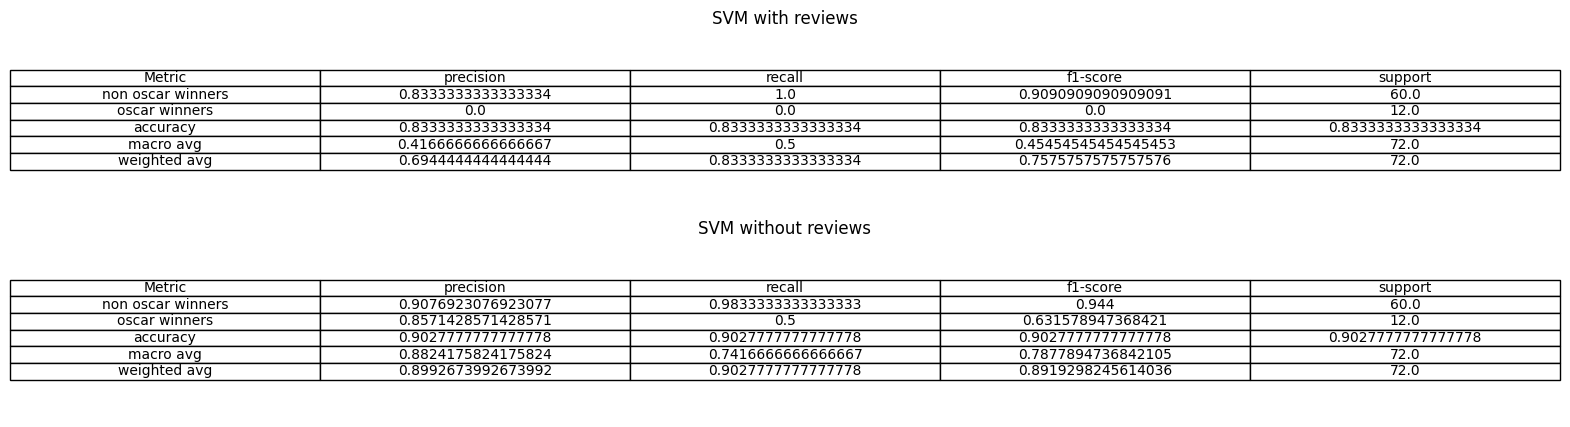

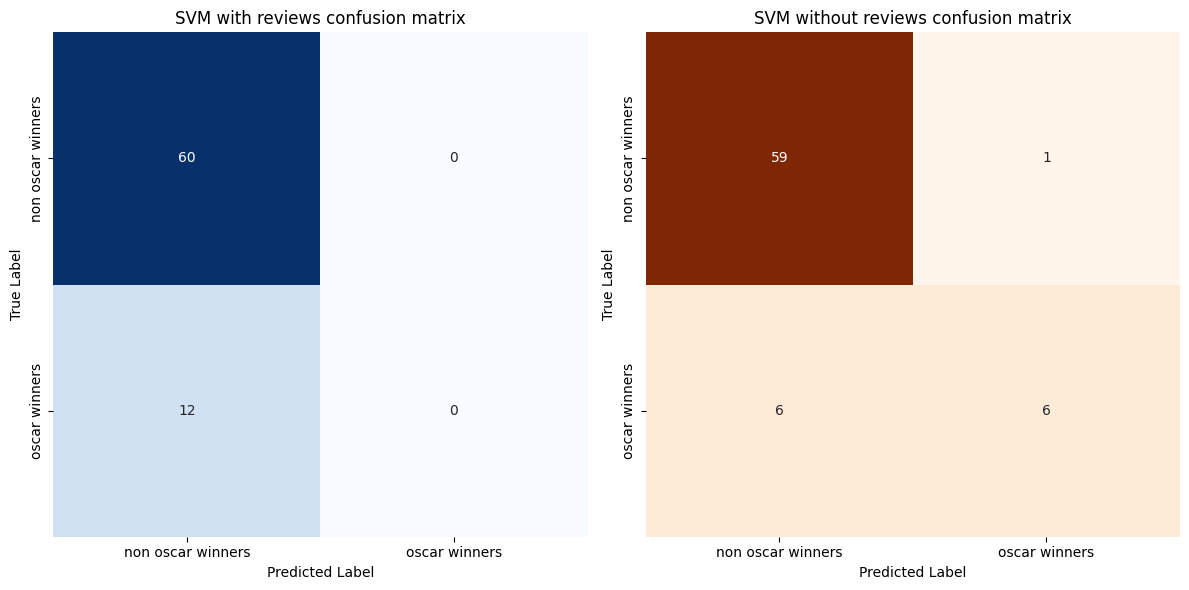

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



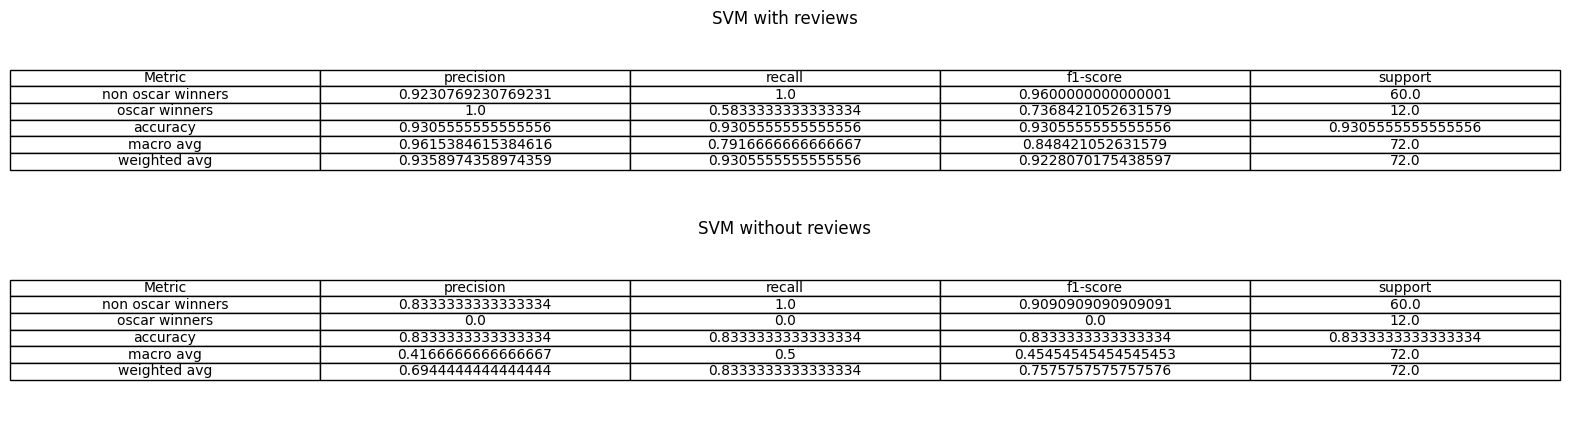

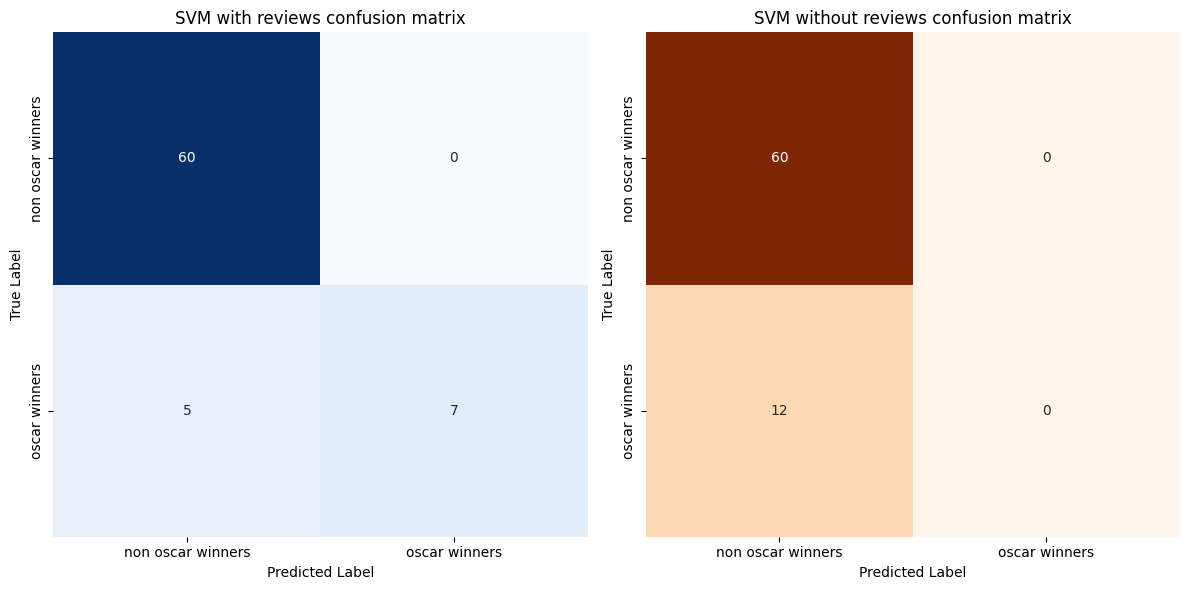

In [ ]:
# Define comparable pairs
pairs_list = [('df_with_embeddings', 'df_wt_embeddings'),
              ('df_with_prediction_sentiment', 'df_all')]

# Plot results for svm model
model_name = 'svm'
plot_and_compare(pairs_list, model_name, models_dict,data_dict)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



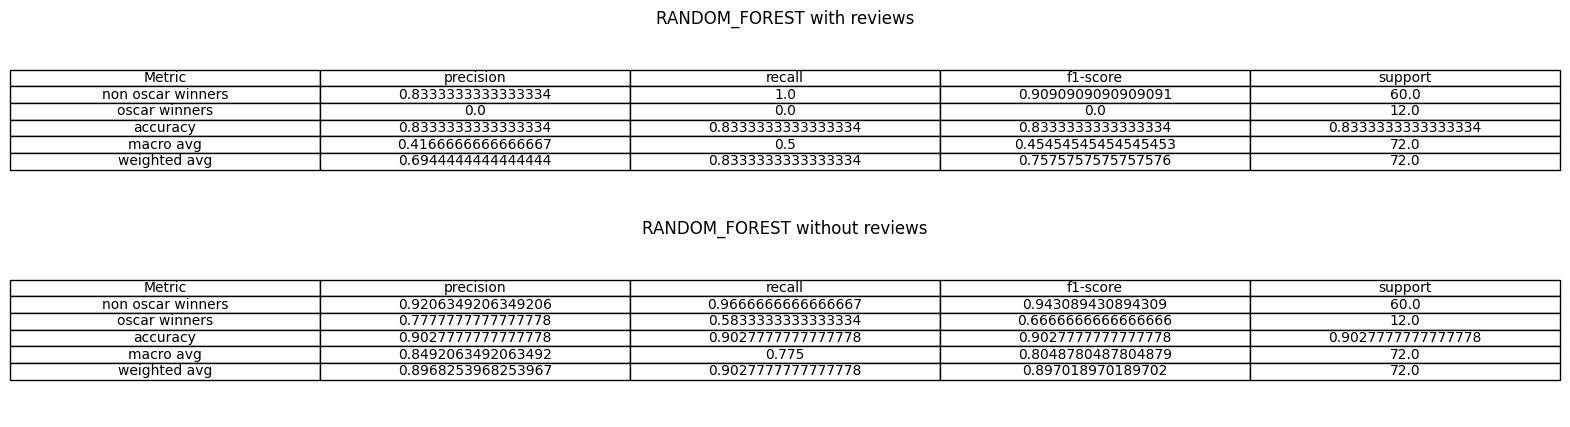

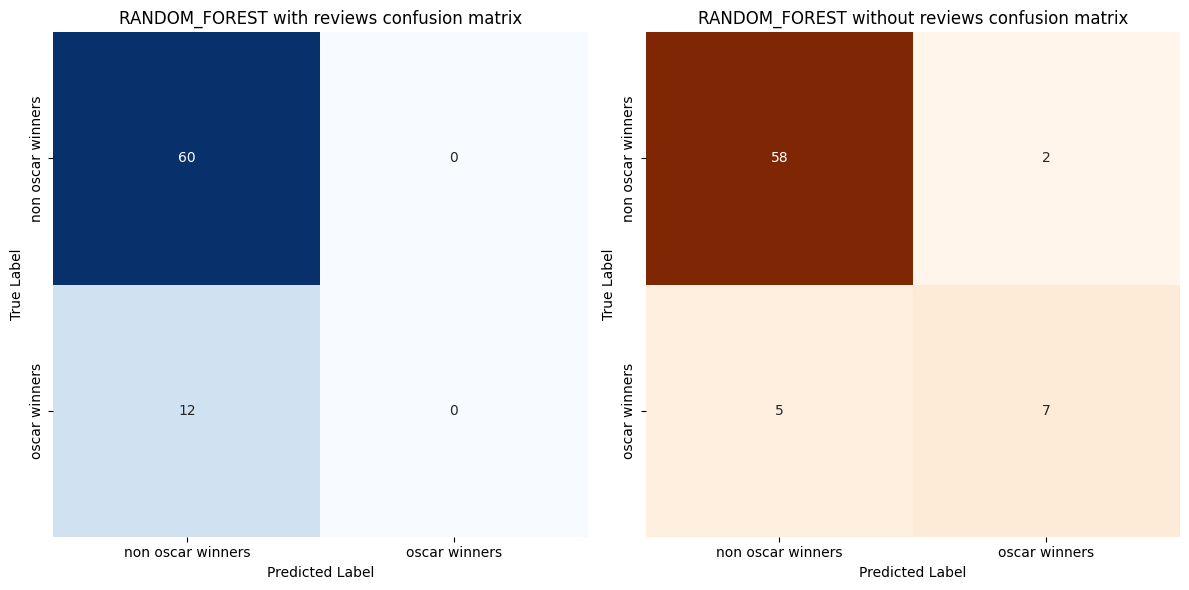

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



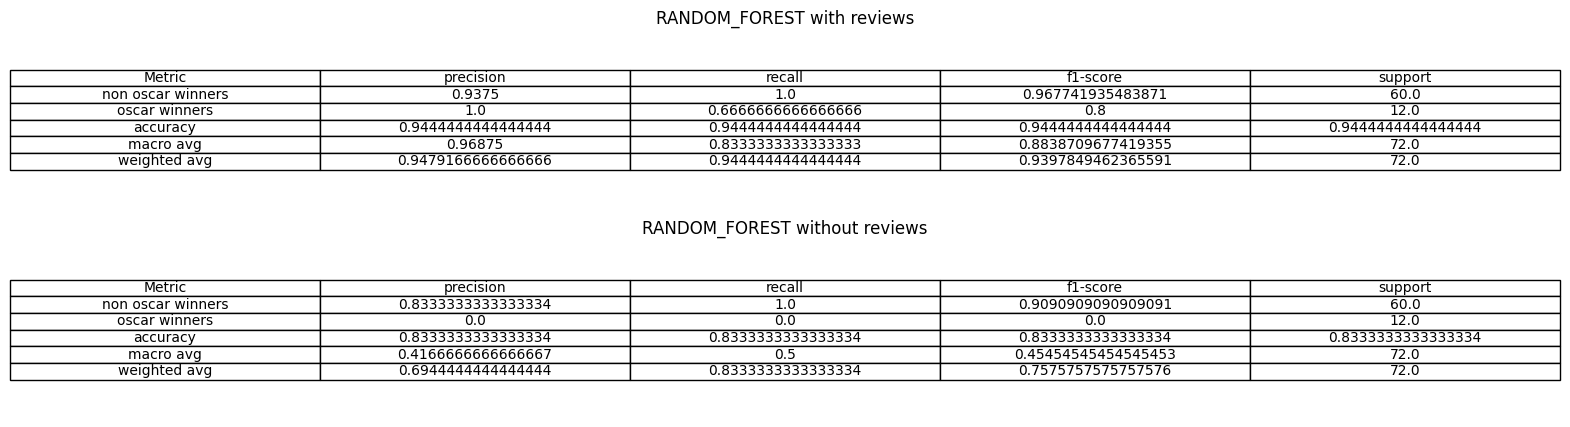

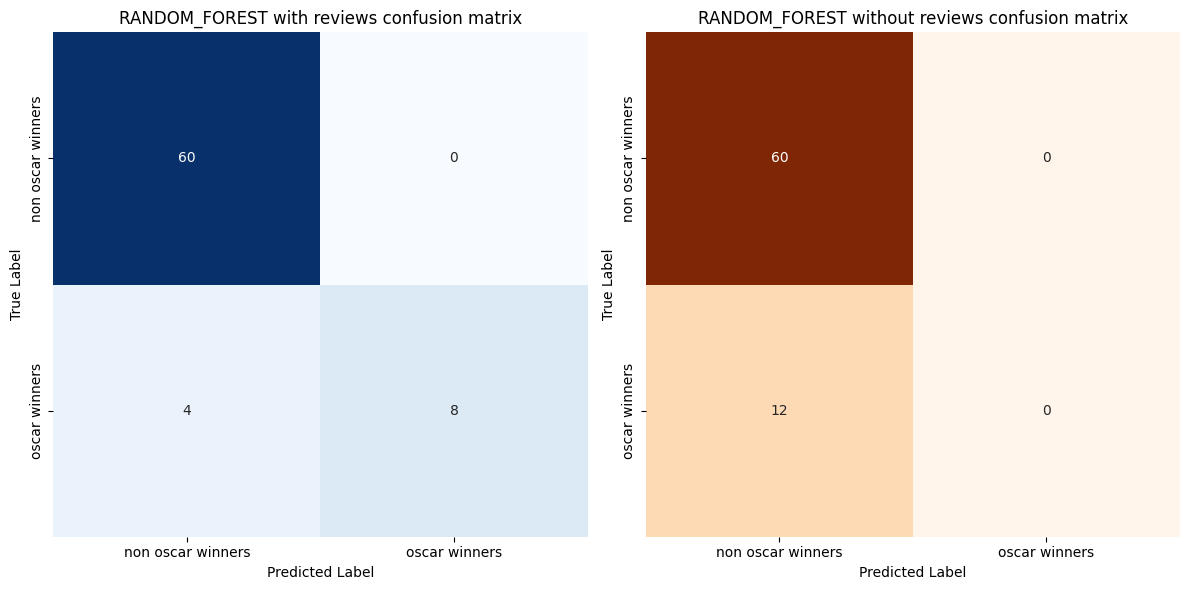

In [ ]:
# Define comparable pairs
pairs_list = [('df_with_embeddings', 'df_wt_embeddings'),
                  ('df_with_prediction_sentiment', 'df_all')]

# Plot results for random forest model
model_name = 'random_forest'
plot_and_compare(pairs_list, model_name, models_dict, data_dict)

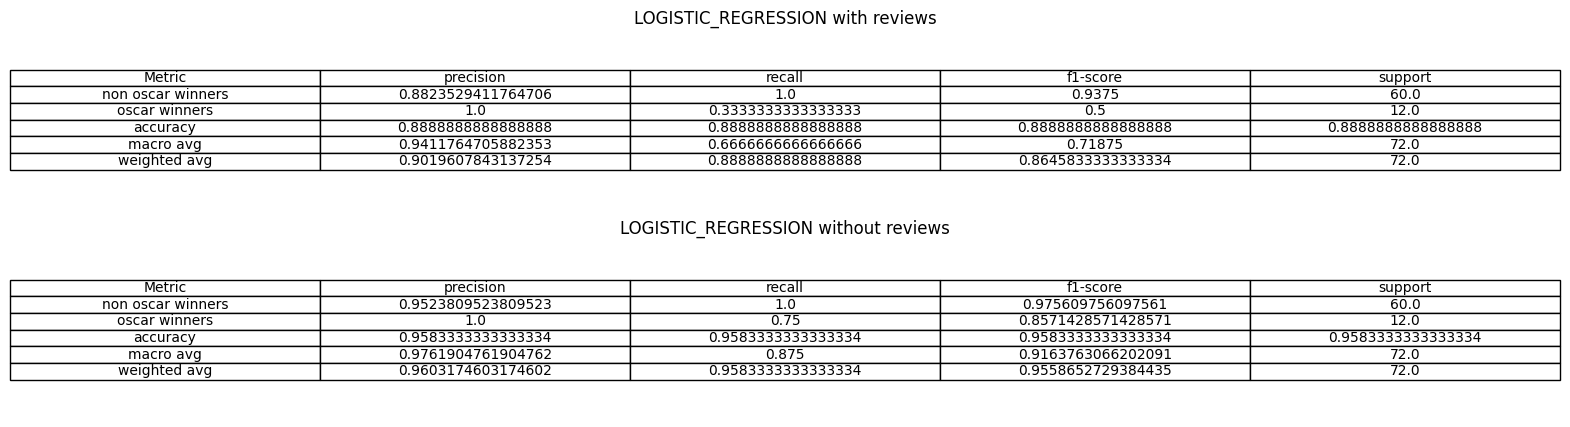

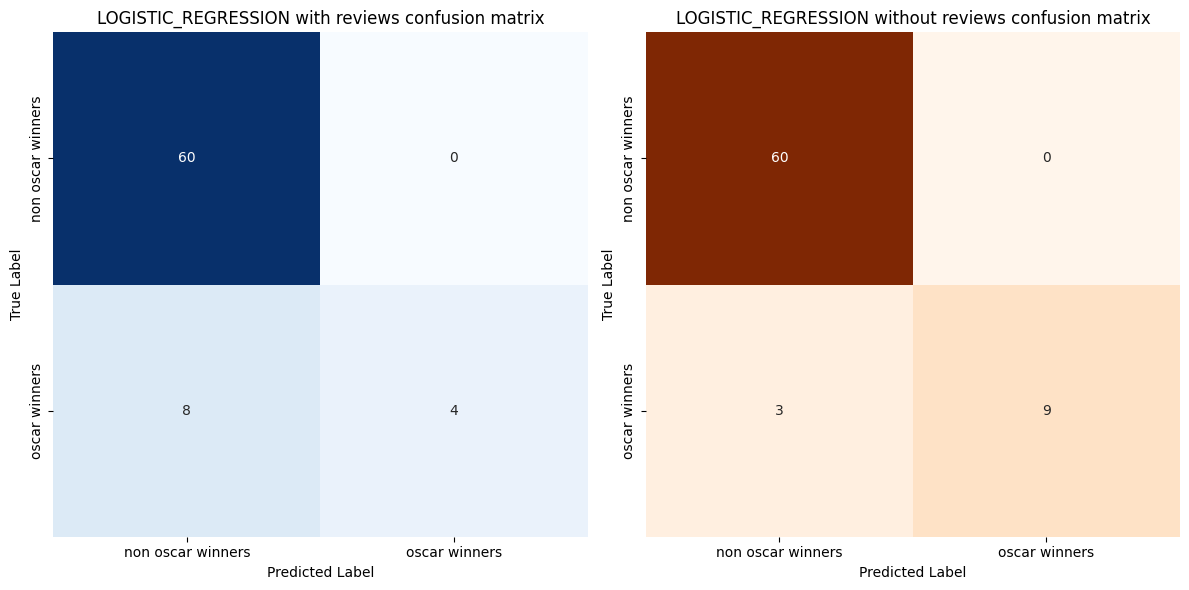

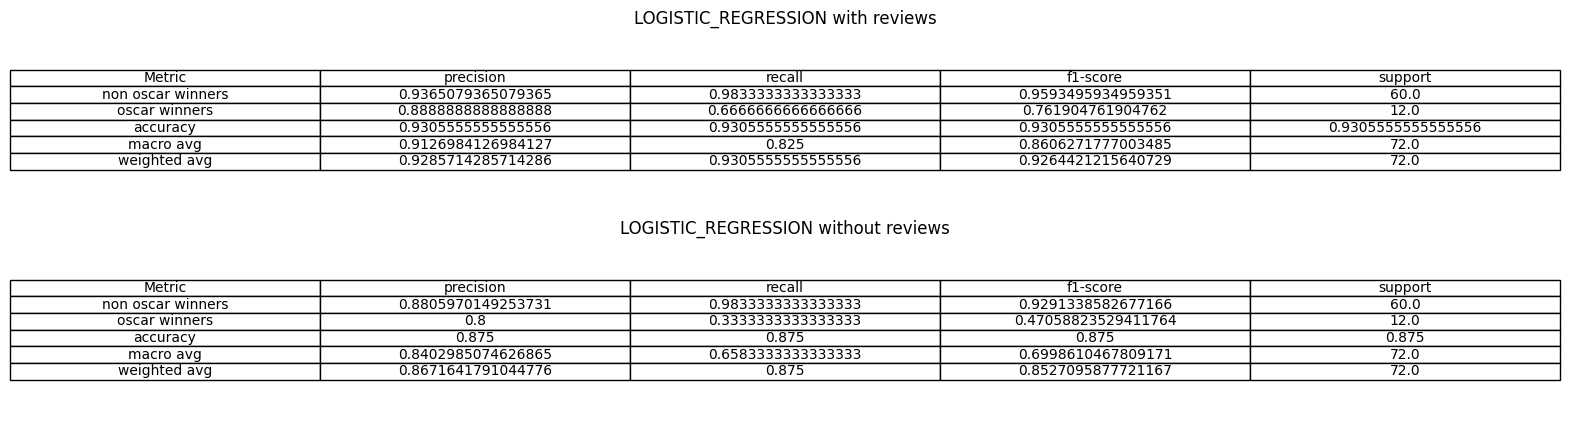

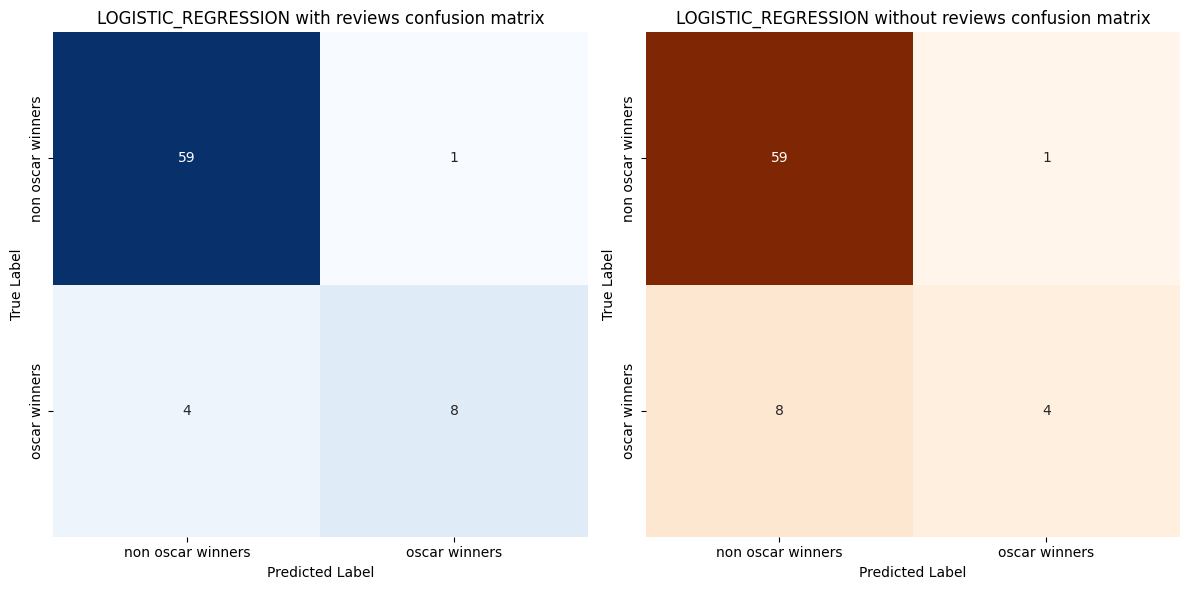

In [ ]:
# Define comparable pairs
pairs_list = [('df_with_embeddings', 'df_wt_embeddings'),
                  ('df_with_prediction_sentiment', 'df_all')]

# Plot results for logistic regression model
model_name = 'logistic_regression'
plot_and_compare(pairs_list, model_name, models_dict, data_dict)

### As we can see all models except logistic regression are struggling with prediction data with reviews 768 text embedding dimension from DistilBert. But the results are better when only logits and sentiment mark are used. It is also obiously that there is imbalance in data distribution

### Cause of these reasons data will be adjuncted with SMOTE and later predictions will be made on the following datasets: df_wt_embeddings and df_with_prediction_sentiment

### But the SMOTE will be used for all data, so you can play around and check results

# Before SMOTE, let's take a look on data distribution using TSNE

In [ ]:
data_pairs_list = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
title_pairs_list = [('Data with embeddings', 'Data without embeddings')]

for key_pair, title_pair in zip(data_pairs_list, title_pairs_list):

    key_1, key_2 = key_pair
    title_1, title_2 = title_pair

    data_1 = dataframes[key_1]
    data_2 = dataframes[key_2]

    tsne_1, tsne_2 = compute_tsne(scaled_data_1=data_1,
                                  scaled_data_2=data_2,
                                  n_comp_1=2, n_comp_2=2)

    print(tsne_1.shape, tsne_2.shape)
    plot_2_TSNE(tsne_1, tsne_2, y, y,
                title_1=title_1, title_2=title_2)

(359, 2) (359, 2)


# Use SMOTE to add data, and have a look on the graphics

In [ ]:
def add_data_smote(X, y):

    """
    This function adds data to imbalanced class

    Parameters:
    X: Data to which will be sampled new data
    y: Labels for data, new labels also will be sampled

    Returns:
    Dataset (tuple) with new data for imbalanced class
    """

    smote = SMOTE(sampling_strategy='auto', random_state=random_state)
    X_art, y_art = smote.fit_resample(X,y)

    return X_art, y_art

## Sample data to imbalanced class

In [ ]:
art_data_dict = copy.deepcopy(data_dict)

# Use SMOTE for all data and add them to new dict
for k, v in art_data_dict.items():

    X_train, X_test, y_train, y_test = v
    art_X_train, art_y_train = add_data_smote(X_train, y_train)

    art_data_dict[k] = (art_X_train, X_test, art_y_train, y_test)

# Check the number of imbalanced class before and after SMOTE
k = 'df_with_embeddings'
X_train, X_test, y_train, y_test = data_dict[k]
art_X_train, X_test, art_y_train, y_test = art_data_dict[k]

counter, art_counter = Counter(y_train), Counter(art_y_train)
print("Before SMOTE embeddings data", counter)
print("After SMOTE embeddings data", art_counter)

Before SMOTE embeddings data Counter({0: 239, 1: 48})
After SMOTE embeddings data Counter({0: 239, 1: 239})


# Let's have a look on X_train with SMOTE and compare it to data without SMOTE

In [ ]:
data_pairs_list = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
title_pairs_list = [('Data with embeddings and with SMOTE', 'Data with embeddings and without SMOTE'),
                    ('Data without embeddings and with SMOTE', 'Data without embeddings and without SMOTE')]
data_list = [(art_data_dict, data_dict)]

for key_pair in data_pairs_list:
    for dict_pair in data_list:
        d_1, d_2 = dict_pair
        for key, title_pair in zip(key_pair, title_pairs_list):
            title_1, title_2 = title_pair

            data_1 = d_1[key]
            X_train_1, _,y_train_1,_ = data_1

            data_2 = d_2[key]
            X_train_2, _,y_train_2,_ = data_2

            tsne_1, tsne_2 = compute_tsne(scaled_data_1=X_train_1,
                                          scaled_data_2=X_train_2,
                                          n_comp_1=2, n_comp_2=2)

            plot_2_TSNE(tsne_1, tsne_2, y_train_1, y_train_2,
                        title_1=title_1, title_2=title_2)

## Conclusions about SMOTE:
**SMOTE (Synthetic Minority Over-sampling Technique)** is a technique used to address class imbalance in datasets by generating synthetic samples of the minority class.

When comparing datasets with and without SMOTE using t-SNE (t-distributed Stochastic Neighbor Embedding), a popular technique for visualizing high-dimensional data in lower dimensions, the main differences you may observe are:

1) **Improved Separation**: With SMOTE, you might see better separation between the classes in the t-SNE plot. This is because SMOTE helps in creating synthetic samples that fill the gaps between clusters, making the classes more distinguishable.

2) **Increased Clustering**: SMOTE can lead to denser clusters of points representing the minority class in the t-SNE plot, as the synthetic samples help in expanding the representation of the minority class in the feature space.

3) **Balanced Distribution**: Without SMOTE, it is obviously observed that there is imbalanced distribution of points in the t-SNE plot, with the majority class dominating the visual representation. In contrast, using SMOTE can lead to a more balanced distribution of points, reflecting the improved class balance in the dataset.

All three main points are presented on the plot

**In summary**, using SMOTE to balance class distribution and add synthetic samples to the minority class can result in improved model performance, better generalization, and more distinct separation between classes in visualizations like t-SNE plots.

# Let's explore how k-means algorithm makes separation on clusters and also let's check the best number of class according to silhouette score

In [ ]:
data_pairs_list = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
title_pairs_list = [('Data with embeddings and with SMOTE', 'Data with embeddings and without SMOTE'),
                    ('Data without embeddings and with SMOTE', 'Data without embeddings and without SMOTE')]

data_list = [(art_data_dict, data_dict)]

for key_pair in data_pairs_list:
    for dict_pair in data_list:
        d_1, d_2 = dict_pair
        for key, title_pair in zip(key_pair, title_pairs_list):
            title_1, title_2 = title_pair

            data_1 = d_1[key]
            X_train_1, _,y_train_1,_ = data_1

            data_2 = d_2[key]
            X_train_2, _,y_train_2,_ = data_2

            k_means_neigbours_graph(scaled_data_1=X_train_1, scaled_data_2=X_train_2,
                                    title_1=title_1, title_2=title_2)

100%|██████████| 49/49 [00:02<00:00, 18.67it/s]


100%|██████████| 49/49 [00:01<00:00, 43.90it/s]


## Conclusions about k-means and silhouette score for datasets

**Silhouette scores** are used to measure the quality of clustering in unsupervised machine learning algorithms like K-means. A higher silhouette score indicates that the clusters are well apart from each other and clearly distinguished. When comparing datasets with and without SMOTE using silhouette scores for the K-means algorithm, the main differences that may be observed are:

1) **Impact on Cluster Separation**: When using SMOTE to balance class distribution, the addition of synthetic samples can lead to clearer separation between clusters in the feature space. It could be seen that higher silhouette scores in datasets with SMOTE as the clusters are better defined and less overlapping compared to datasets without SMOTE.

2) **Effect on Cluster Purity**: SMOTE may help improve the purity of clusters by ensuring that the minority class is adequately represented in the dataset. This can lead to more cohesive and distinct clusters, reflected in higher silhouette scores for datasets with SMOTE compared to those without it.

3) **Handling Class Imbalance**: In datasets without SMOTE, class imbalance can often result in skewed clustering, with the majority class dominating the clusters. By using SMOTE to address class imbalance, the K-means algorithm can perform better in distinguishing between different classes, leading to improved silhouette scores.

According to the notes above it is really that Silhouette score for data with SMOTE with 2 classes are higher than without it. However, SMOTE also creates more clusters for our data in such way that Silhouette score is higher for the number of classes than 2 which could complikate prediction for models on test set

# Train models and check the results

## Train models on data with SMOTE. You can try default parameters but in the following parameters will be obtained via grid search. By the way, models trained on data with SMOTE and embeddings give better prediction, and such results can be explored after using grid search

In [ ]:
models = ['svm', 'random_forest', 'logistic_regression']
art_models_dict = {}
params_dict = {'svm':{'random_state':101},
               'random_forest':{'random_state':101, 'n_estimators':250},
               'logistic_regression':{'random_state':101,'max_iter':5000, 'solver':"newton-cg"}}

for model in models:
    current_dict = art_models_dict[model] = {}
    params = params_dict[model]
    for k, data_tuple in art_data_dict.items():
        X_train, _, y_train, _ = data_tuple
        current_dict[k] = get_trained_model(X_train, y_train, model_name=model, **params)

## Define function to get optimal parameters for the models

In [ ]:
def use_searchgrid(models, data_dict, params_grid, keys, scoring='f1', verbose=3):

    """
    This function selects parameters for the models using grid search
    on passed data with specified params

    Parameters:
    models (list): List with model names (also these are the keys for params_grid)
    params_grid (dict): Nested grid with train parameters for each model in
    models list

    data_dict (dict): Dict with data on which models will be trained
    keys (list): List with pair keys for the data_dict
    scoring (str): Specify which metric to use when test parameters for model on
    test data (from data_dict)
    verbose (int) : This variable specify how much information to print

    Returns:
    grid_dict (dict) that contains models and best parameters which are found
    on test data
    """

    # define the data
    grid_dict = {}

    # Choose which model to train
    for model in models:
        current_dict = grid_dict[model] = {}

        if model == 'svm':
            estimator = SVC()
        elif model == 'random_forest':
            estimator = RandomForestClassifier()
        else:
            estimator = LogisticRegression()

        # Get params according to the model name
        param_grid = params_grid[model]

        for key_pair in keys:
            for k in key_pair:
                # Retrieve the data from the dict
                X_train, X_test, y_train, y_test = data_dict[k]
                # Concatenate train and test data into one array
                x, y = np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=0)
                # Specify the data indeces (1 for train and 0 for test)
                test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_test.shape[0])]
                ps = PredefinedSplit(test_fold)
                # Initialise grid search
                grid = GridSearchCV(estimator, param_grid, refit = False, verbose = verbose, cv=ps, scoring=scoring)
                # fitting the model for grid search
                grid.fit(x, y)

                current_dict[k] = grid

    return grid_dict

In [ ]:
def get_temporary_dict(grid_dict, keys, data_dict, model_name):

    """
    This function creates temporary dict and fill in models trained one the
    best params from grid search to plot results

    Parameters:
    grid_dicr (dict): Models from grid dict and best parameters for them
    keys (list): List with data pair of key to data_dict
    data_dict (dict): Dict that contains data on which model will be trained on
    with the best parameters

    model_name (str): Name for the model

    Returns:
    temporary_dict (dict): Dict with models trained on keys data with the best
    parameters
    """
    temporary_dict = {model_name:{}}
    for key_pair in keys: # iterate over data pairs
        for key in key_pair: # iterate over data in a pair
            # Get best parameters of the model
            dict_with_params = grid_dict[model_name][key].best_params_
            # Retrieve data
            X_train, _, y_train, _ = data_dict[key]
            # Train model
            trained_model = get_trained_model(X_train, y_train, model_name=model_name, **dict_with_params)
            # Append model and data
            temporary_dict[model_name][key] = trained_model

    return temporary_dict

Fitting 1 folds for each of 144 candidates, totalling 144 fits
[CV 1/1] END C=0.1, gamma=0.03, kernel=rbf, random_state=101;, score=0.588 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.03, kernel=rbf, random_state=102;, score=0.588 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.03, kernel=poly, random_state=101;, score=0.556 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.03, kernel=poly, random_state=102;, score=0.556 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.02, kernel=rbf, random_state=101;, score=0.737 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.02, kernel=rbf, random_state=102;, score=0.737 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.02, kernel=poly, random_state=101;, score=0.500 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.02, kernel=poly, random_state=102;, score=0.500 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.01, kernel=rbf, random_state=101;, score=0.762 total time=   0.0s
[CV 1/1] END C=0.1, gamma=0.01, kernel=rbf, random_state=102;, score=0.762 total time= 

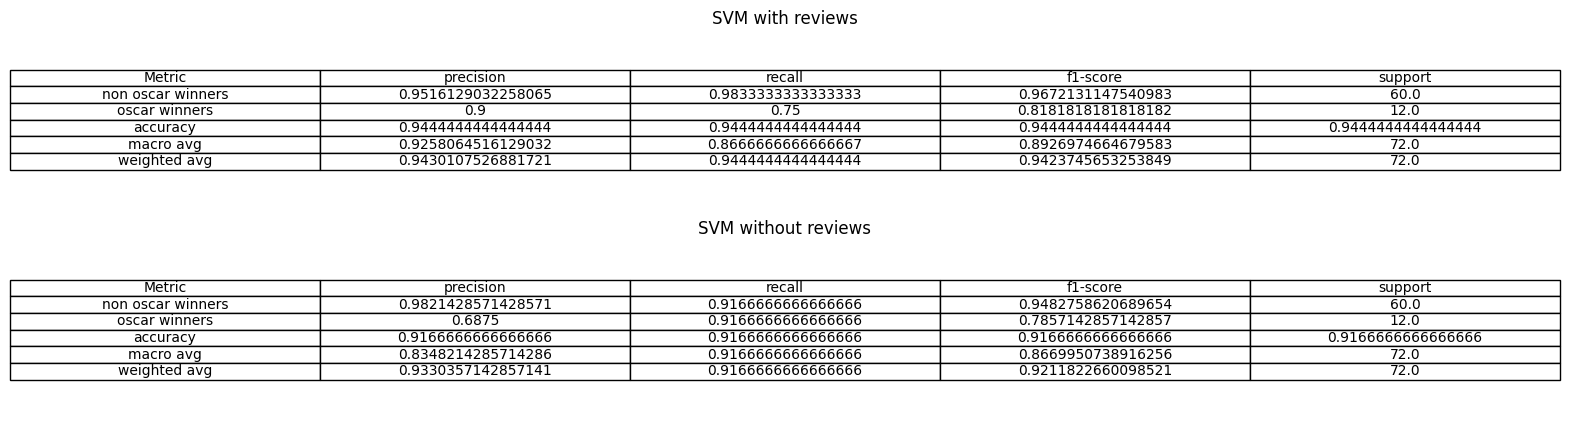

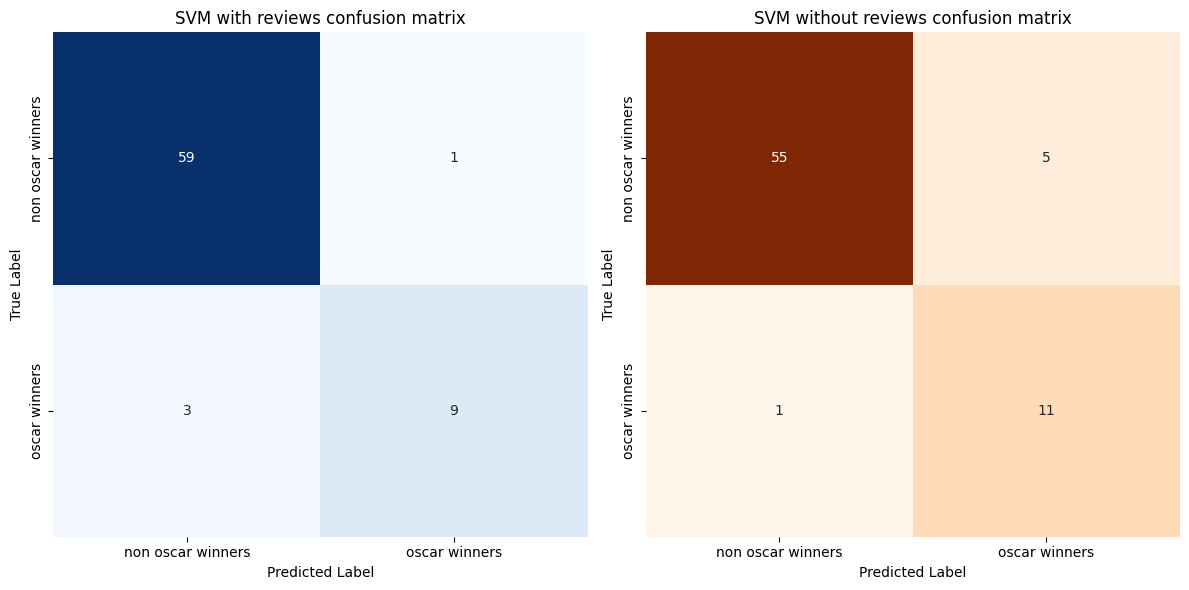

In [ ]:
keys = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
models_name = ['svm']
# defining parameter range
params_grid = {
              'svm':
               {'C': [0.1, 0.5, 1, 10, 100, 1000],
              'gamma': [0.03, 0.02, 0.01, 0.0001,0.0002, 0.0003],
              'kernel': ['rbf', 'poly'],
              'random_state':[101,102]},
               }

grid_dict = use_searchgrid(models_name, art_data_dict, params_grid, keys, scoring='f1', verbose=3)


for model_name in models_name: # iterate over model name
    temporary_model_dict = get_temporary_dict(grid_dict, keys,
                                              data_dict=art_data_dict,
                                              model_name=model_name)

    # Plot the test results
    plot_and_compare(keys, model_name,
                    models_dict=temporary_model_dict,
                    data_dict=art_data_dict)

Fitting 1 folds for each of 810 candidates, totalling 810 fits
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=16, random_state=101;, score=0.667 total time=   0.1s
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=16, random_state=102;, score=0.762 total time=   0.1s
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=17, random_state=101;, score=0.667 total time=   0.1s
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=17, random_state=102;, score=0.762 total time=   0.1s
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=18, random_state=101;, score=0.667 total time=   0.1s
[CV 1/1] END max_depth=8, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=18, random_state=102;, score=0.762 total time=   0.1s
[CV 1/1] END max_de

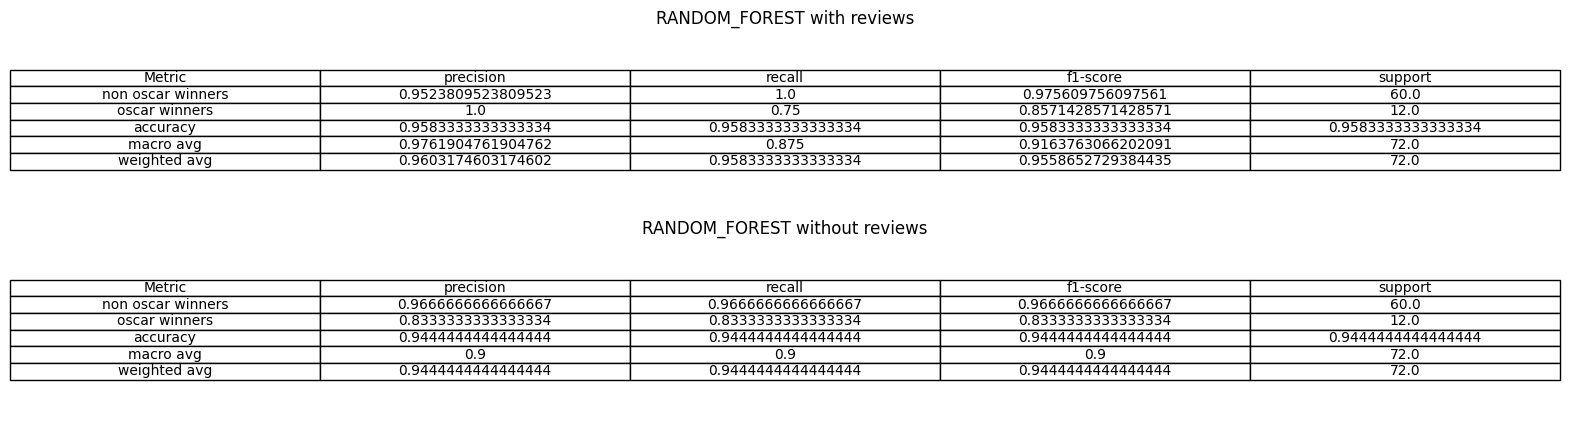

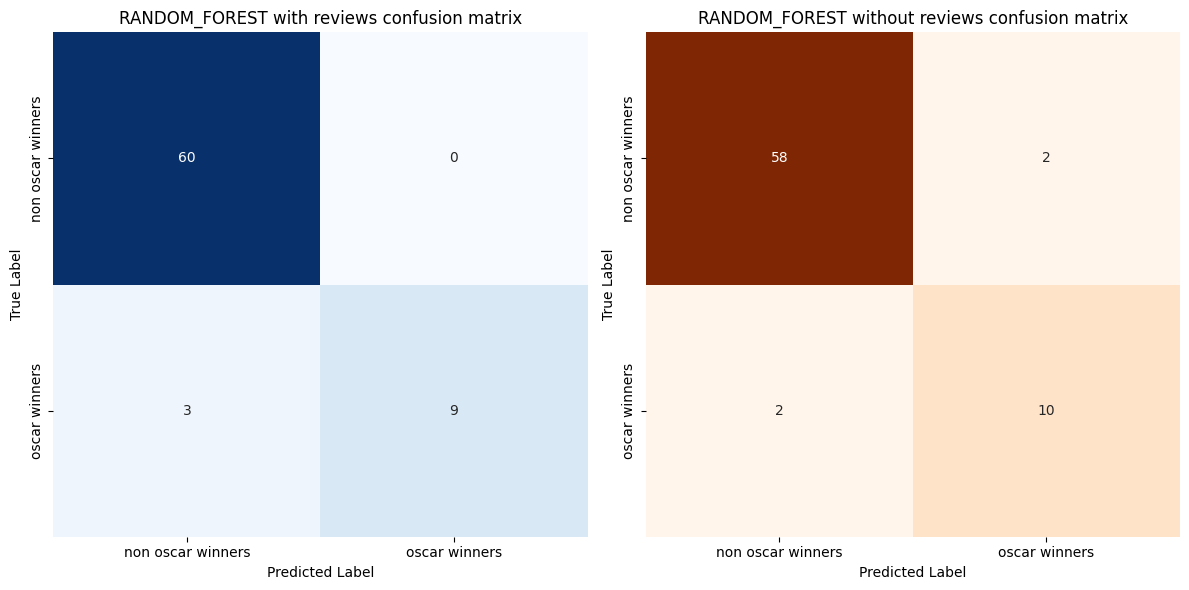

In [ ]:
keys = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
models_name = ['random_forest']
# defining parameter range
params_grid = {
              'random_forest':
               {'max_depth':[8,9,10],
              'n_estimators':[16,17,18],
              'max_features':['sqrt', 11, 12,13, None],
              'min_samples_leaf':[6,7,8],
              'min_samples_split':[6,7,8],
              'random_state':[101, 102]},
               }

grid_dict = use_searchgrid(models_name, art_data_dict, params_grid, keys, scoring='f1', verbose=3)


for model_name in models_name: # iterate over model name
    temporary_model_dict = get_temporary_dict(grid_dict, keys,
                                              data_dict=art_data_dict,
                                              model_name=model_name)

    # Plot the test results
    plot_and_compare(keys, model_name,
                    models_dict=temporary_model_dict,
                    data_dict=art_data_dict)

Fitting 1 folds for each of 384 candidates, totalling 384 fits
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=101, solver=newton-cg;, score=0.870 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=101, solver=liblinear;, score=0.629 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=102, solver=newton-cg;, score=0.870 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=102, solver=liblinear;, score=0.629 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l1, random_state=101, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l1, random_state=101, solver=liblinear;, score=0.78

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


96 fits failed out of a total of 384.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

Fitting 1 folds for each of 384 candidates, totalling 384 fits
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=101, solver=newton-cg;, score=0.846 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=101, solver=liblinear;, score=0.611 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=102, solver=newton-cg;, score=0.846 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l2, random_state=102, solver=liblinear;, score=0.611 total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l1, random_state=101, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/1] END C=0.008, fit_intercept=True, intercept_scaling=0.35, max_iter=100, penalty=l1, random_state=101, solver=liblinear;, score=0.78

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


96 fits failed out of a total of 384.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

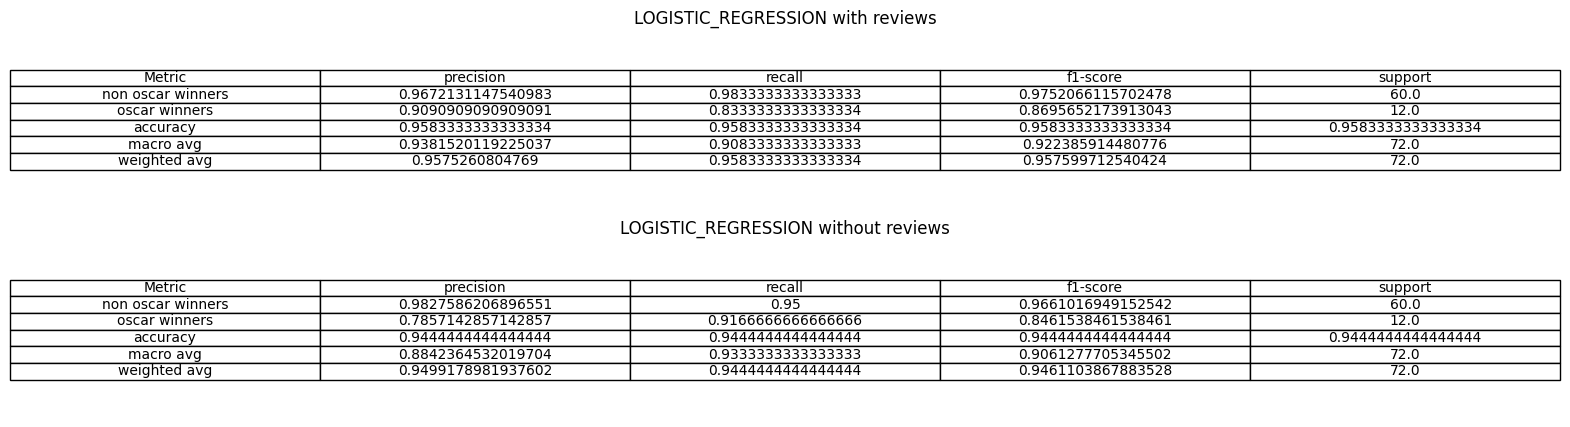

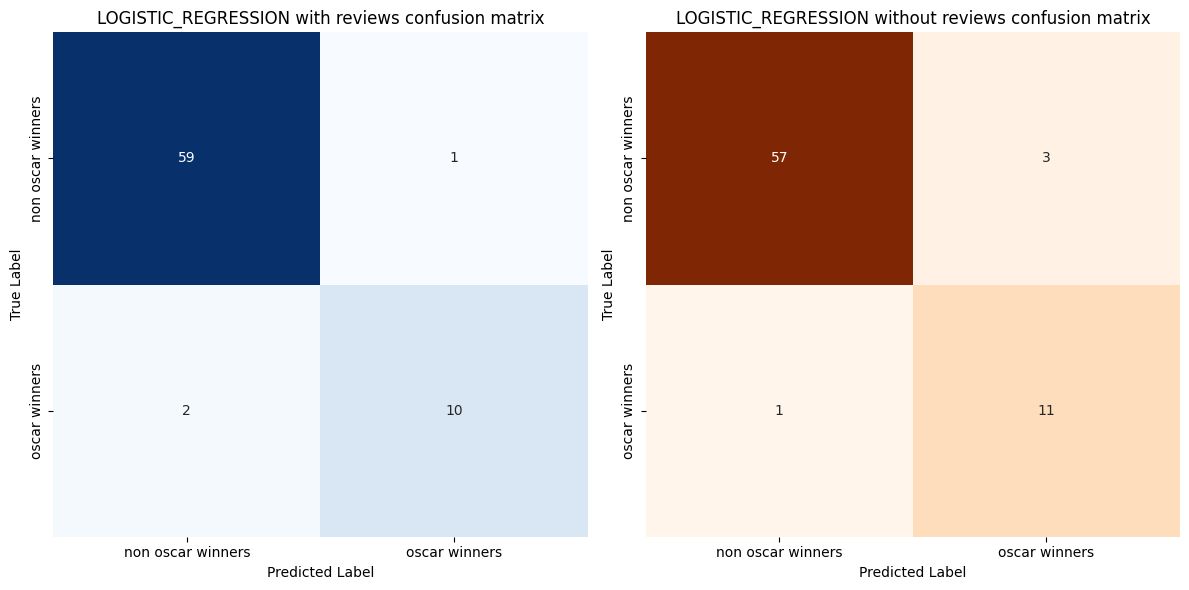

In [ ]:
keys = [('df_with_prediction_sentiment', 'df_wt_embeddings')]
models_name = ['logistic_regression']
# defining parameter range
params_grid = {
              'logistic_regression':
               {'solver':['newton-cg', 'liblinear'],
                'max_iter':[100, 150],
                'penalty': ['l2', 'l1'],
                'random_state': [101, 102],
                'C': [0.008, 0.01, 0.03, 0.05],
                'fit_intercept':[True, False],
                'intercept_scaling':[0.35, 0.4, 0.45],
               }
               }

grid_dict = use_searchgrid(models_name, art_data_dict, params_grid, keys, scoring='f1', verbose=3)

for model_name in models_name: # iterate over model name
    temporary_model_dict = get_temporary_dict(grid_dict, keys,
                                              data_dict=art_data_dict,
                                              model_name=model_name)

    # Plot the test results
    plot_and_compare(keys, model_name,
                    models_dict=temporary_model_dict,
                    data_dict=art_data_dict)

## Conclusions about trained models on data with SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique)** is a technique used to address class imbalance in datasets by generating synthetic samples of the minority class. When using the SMOTE library to add data to a dataset, the following improvements can be expected for models:

1) **Improved Model Performance**: By adding synthetic samples to the minority class, SMOTE helps balance the class distribution in the dataset. This leads to better training of machine learning models, reduced bias towards the majority class, and improved prediction performance, especially for classifiers that are sensitive to class imbalance.

2) **Reduced Overfitting**: The synthetic samples generated by SMOTE help in providing more representative training data for the minority class, which can reduce overfitting that may occur when training on imbalanced datasets.

3) **Enhanced Generalization**: The balanced dataset produced by SMOTE can help models generalize better to unseen data, as they are exposed to a more diverse range of samples from the minority class.

### ***There is also very important note***:

Using grid search may greatly differ depending on as chosen parameters as data (for instance, on train_test_split parameter)

During finetuning experiments for such parameters, author of this notebook **always tried to get the best for both data with text embeddings and without one.** As a result, models trained on data with text embeddings **always** shows better score on **f1 metric** if the best parameters for each models are chosen precisely


# Main conclusions

In this notebook the following steps were made:

1) **Retrieved text embeddings** using reviews from metacritic and rotten tomattoes. These embeddings supplied dataset for oscar prediction. Also there was a bit of cleaning process for dataset to drop some columns and films with the same name ("West Side Story")

2) On this dataset **three models are trained**: SVM, logistic regression and random forest.

3) However, initially dataset is imbalanced, so **SMOTE algorithm is applied** to solve this problem

4) Besides, **additional data analysis is present** in the notebook. For this purpose TSNE was used to shrink and plot train data in 2 dimensions. Silhouette score is also applied and according to it and TSNE classes with **SMOTE and text embeddings** are distinguished much better

5) **The same models were trained** on data with SMOTE. According to the results, **models give higher f1 score on data with text embeddings and SMOTE**. The best model trained on data with SMOTE and text embeddings is logistic regression      (*model's parameters could be found in the notebook*) **with train_test_split parameter is 0.2 and f1 is equal to 0.87**